In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from warnings import filterwarnings
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

filterwarnings('ignore')

%store -r df

res = df[~((df.duplicated(['session_id'])) & (df['target_event']==0) )]
res = res.sample(n=200000).reset_index(drop=True)
for col in res.columns:
    res[col] = res[col].fillna('unknown')
    
drop_features=['session_id', 'client_id', 'visit_time', 'visit_number', 'device_model', 'device_screen_resolution', 'utm_keyword']
res = res.drop(drop_features, axis=1)
res['target_event'] = res['target_event'].astype(np.int8)

In [2]:
def view_occupancy(df):
    length = len(df)
    dic = dict()
    for col in df.columns:
        percent_filled = (length-df[col].isna().sum())/length
        dic[col] = percent_filled

    dic = sorted(dic.items(), key=lambda x: x[1], reverse=True)
    for k, v in dic:
        print('{}: {:.3f}%, {}'.format(k, v*100, df[k].isna().sum()))

view_occupancy(res)

visit_date: 100.000%, 0
utm_source: 100.000%, 0
utm_medium: 100.000%, 0
utm_campaign: 100.000%, 0
utm_adcontent: 100.000%, 0
device_category: 100.000%, 0
device_os: 100.000%, 0
device_brand: 100.000%, 0
device_browser: 100.000%, 0
geo_country: 100.000%, 0
geo_city: 100.000%, 0
target_event: 100.000%, 0


In [3]:
def change_feature(x):
    grouped = res.groupby([x])['target_event'].mean().to_frame().reset_index()
    res[x]=res[x].apply(lambda a: grouped.loc[grouped[x]==a, 'target_event'].iloc[0])
    res[x]=res[x].astype(np.float64)

In [4]:
res['visit_date'] = pd.to_datetime(res['visit_date'])
res['month'] = res['visit_date'].apply(lambda x: int(x.month)).astype(np.int8)
res = res.drop(['visit_date'], axis=1)

In [5]:
source_features = ['QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 'ISrKoXQCxqqYvAZICvjs', 
                   'IZEXUFLARCUMynmHNBGo', 'PlbkrSYoHuZBWfYjYnfw', 'gVRrcxiDQubJiljoTbGm']
res['utm_source'] = res['utm_source'].fillna('0')
res['utm_source'] = res['utm_source'].apply(lambda x: 1 if x in source_features else 0).astype(np.int8)

In [6]:
utm_medium_type = ['organic', 'referral', '(none)']
res['utm_medium'] = res['utm_medium'].apply(lambda x: 1 if x in utm_medium_type else 0).astype(np.int8)

In [7]:
res['utm_campaign'] = res['utm_campaign'].apply(lambda a: 0 if a=='unknown' else 1).astype(np.int8)

In [8]:
# change_feature('utm_campaign')
# change_feature('utm_adcontent')
change_feature('device_category')

In [9]:
res['utm_adcontent'] = res['utm_adcontent'].apply(lambda a: 0 if a=='unknown' else 1).astype(np.int8)

In [10]:
res['device_os'] = res['device_os'].apply(lambda a: 1 if a in ['Android', 'iOS'] else 0).astype(np.int8)

In [11]:
res['device_brand'] = res['device_brand'].fillna('other')
res['device_brand'] = res['device_brand'].apply(lambda a: 1 if a != 'Apple' else 0).astype(np.int8)

In [12]:
def foo_browser(x):
    t = 0
    if x in ['Chrome', 'Safari', 'YaBrowser']:
        t = 2
    elif x in ['Safari (in-app)', 'Android Webview', 'Samsung Internet']:
        t = 1
    else:
        t = 0
    return t

res['device_browser'] = res['device_browser'].apply(lambda x: foo_browser(x)).astype(np.int8)

In [13]:
res['geo_country'] = res['geo_country'].apply(lambda x: 1 if x=='Russia' else 0).astype(np.int8)

In [14]:
res['geo_city'] = res['geo_city'].apply(lambda a: 1 if a in ['Moscow', 'Saint Petersburg'] else 0).astype(np.int8)

In [15]:
# res.info()

<AxesSubplot:>

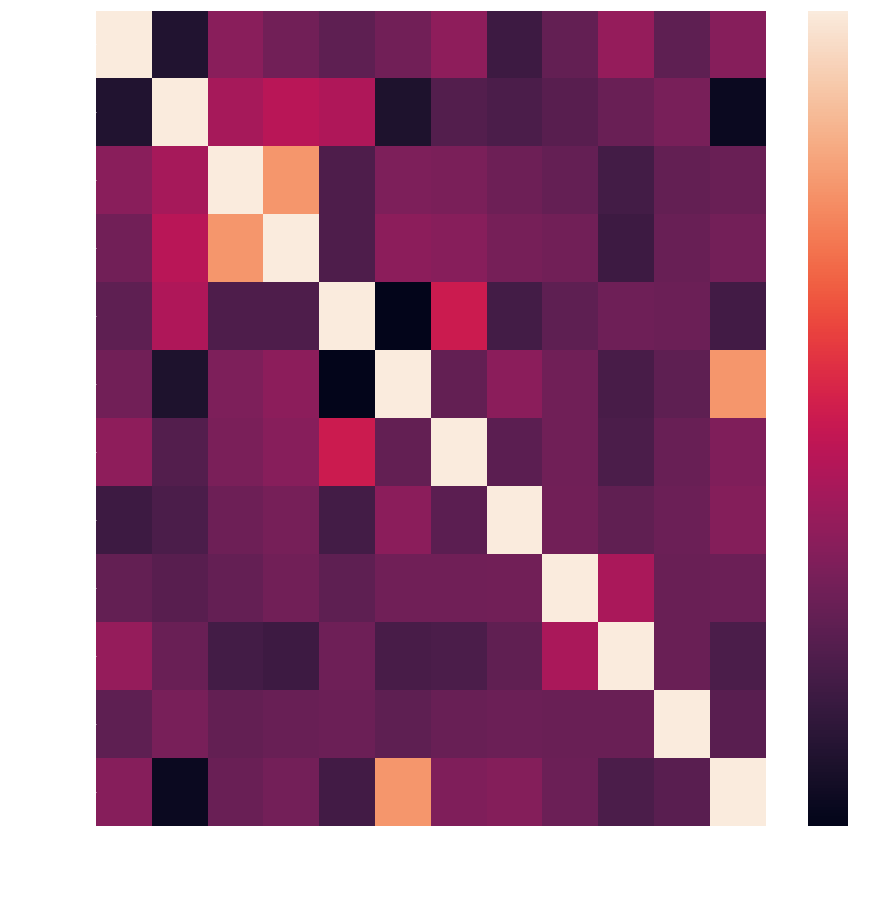

In [16]:
fit, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(res.corr(), ax=ax)

In [17]:
corr_matrix = res.corr()
corr_matrix["target_event"].sort_values(ascending=False)

target_event       1.000000
utm_medium         0.050445
device_category    0.012181
device_browser     0.009838
geo_city           0.005776
geo_country        0.003797
device_brand       0.000749
utm_adcontent     -0.000930
utm_campaign      -0.017567
device_os         -0.031202
utm_source        -0.033279
month             -0.049248
Name: target_event, dtype: float64